In [11]:
import re
import torch
import json
import libcst as cst
import pandas as pd
from rouge_score import rouge_scorer
from rapidfuzz.distance import Levenshtein
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, PreTrainedTokenizerBase, PreTrainedModel
from huggingface_hub import model_info
from huggingface_hub.utils import RepositoryNotFoundError
from datasets import load_dataset
import logging
import os

In [12]:
def setup_logging() -> None:

    level = os.getenv("LOG_LEVEL", "INFO").upper()
    logging.basicConfig(
        level=level,
        format="%(asctime)s [%(levelname)s] %(message)s"
    )

setup_logging()
logger = logging.getLogger(__name__)

In [13]:
class Obfuscator:

    def run(self, code: str, level:str = "low") -> str:
        level = level.lower().strip()
        module = cst.parse_module(code)

        if level == "low":
            module = module.visit(self.__RenameValues())
        elif level == "medium":
            module = module.visit(self.__RenameValues())
            module = module.visit(self.__StripComments())
            module = module.visit(self.__StripDocstrings())
        else:
            raise ValueError(f"Unknown level: {level}")


        return module.code

    class __RenameValues(cst.CSTTransformer):
        def __init__(self):
            self.scopes = []
            self.counter = 0

        def visit_FunctionDef(self, node: cst.FunctionDef):
            self.__push_scope()

            for p in node.params.params:
                self.__bind_current(p.name.value)

            return None

        def leave_FunctionDef(self, original, updated):
            self.__pop_scope()
            return updated

        def leave_Param(self, original: cst.Param, updated: cst.Param):

            new = self.__find(original.name.value)

            if new is not None and original.name.value not in ("self", "cls"):
                return updated.with_changes(name=cst.Name(new))

            return updated

        def leave_Assign(self, original: cst.Assign, updated: cst.Assign):

            new_targets = []
            for target in updated.targets:

                t = target.target

                if isinstance(t, cst.Name):

                    target_value = t.value
                    self.__bind_current(target_value)
                    new = self.__find(target_value)

                    if new is not None:
                        t = cst.Name(new)

                new_targets.append(target.with_changes(target=t))

            return updated.with_changes(targets=new_targets)

        def leave_Name(self, original: cst.Name, updated: cst.Name):

            new = self.__find(original.value)

            if new is not None:
                return updated.with_changes(value=new)

            return updated



        def __push_scope(self):
            self.scopes.append({})

        def __pop_scope(self):
            self.scopes.pop()

        def __new_name(self) -> str:
            name = f"v{self.counter}"
            self.counter += 1
            return name


        def __find(self, name: str):

            for sc in reversed(self.scopes):
                if name in sc:
                    return sc[name]
            return None

        def __bind_current(self, old: str) -> None:

            if old in ("self", "cls"):
                return

            cur = self.scopes[-1]
            if old not in cur:
                cur[old] = self.__new_name()



    class __StripComments(cst.CSTTransformer):
        def leave_Comment(self, original: cst.Comment, updated: cst.Comment):
            return cst.RemovalSentinel.REMOVE

    class __StripDocstrings(cst.CSTTransformer):
        def leave_Module(self, original, updated):
            return updated.with_changes(body=self.__strip(updated.body))

        def leave_ClassDef(self, original, updated):

            if isinstance(updated.body, cst.IndentedBlock):

                new_body = self.__strip(updated.body.body)
                return updated.with_changes(body=updated.body.with_changes(body=new_body))

            return updated

        def leave_FunctionDef(self, original, updated):

            if isinstance(updated.body, cst.IndentedBlock):
                new_body = self.__strip(updated.body.body)
                return updated.with_changes(body=updated.body.with_changes(body=new_body))
            return updated

        def __strip(self, statemnts):

            if not statemnts:
                return statemnts

            i = 0
            while (i < len(statemnts) and isinstance(statemnts[i], cst.EmptyLine)):
                i += 1

            if i < len(statemnts):

                first = statemnts[i]

                if (
                    isinstance(first, cst.SimpleStatementLine)
                    and len(first.body) == 1
                    and isinstance(first.body[0], cst.Expr)
                    and isinstance(first.body[0].value, cst.SimpleString)
                ):
                    return list(statemnts[:i]) + list(statemnts[i + 1:])

            return statemnts

In [42]:
def huggingface_completion(prompt: str,
                           tokenizer: PreTrainedTokenizerBase,
                           model: PreTrainedModel,
                           device: str = "cpu",
                           max_tokens: int = 128) -> str:

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=False,
            num_beams=5,
            early_stopping=True,
            pad_token_id=tokenizer.pad_token_id,   # ВАЖНО: pad, не eos
            eos_token_id=tokenizer.eos_token_id,   # можно оставить явно
        )

    raw = tokenizer.decode(out_ids[0], skip_special_tokens=False)

    if "<extra_id_0>" in raw:
        after = raw.split("<extra_id_0>", 1)[1]
    else:
        after = raw

    for stop in ("<extra_id_1>", "</s>"):
        if stop in after:
            after = after.split(stop, 1)[0]

    for tok in ("<pad>", "<s>", "</s>"):
        after = after.replace(tok, "")

    completion = after.strip()
    return completion

In [43]:
def generate_completions(model_name="Salesforce/codet5p-220m-py" , save_filename = "generated_completions", lines: int = 20):

    dataset_name = "openai/openai_humaneval"
    logger.info(f"Loading dataset '{dataset_name}' ...")

    try:
        ds = load_dataset(dataset_name, split="test")
    except Exception as e:
        logger.error(f"Failed to load dataset '{dataset_name}': {type(e).__name__}")
        raise

    logger.info(
        f"Dataset '{dataset_name}' loaded successfully "
        f"(samples={len(ds)})"
    )

    ####################################
    ### IF U WANT TO USE LOCAL DATASET
    # ds = load_dataset(
    #     "json",
    #     data_files="./something.jsonl",
    #     split="train"
    # )

    subds = ds.select(range(lines))

    results = []
    obf = Obfuscator()

    try:
        model_info(model_name)
        logger.debug(f" Model '{model_name}' found.")
    except RepositoryNotFoundError:
        logger.error(f"[ERROR] Model '{model_name}' does NOT exist on Hugging Face Hub. Exiting...")
        return

    logger.info(f"Loading model '{model_name}'...")

    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    except Exception as e:
        logger.error(
            f"Failed to load model '{model_name}': {type(e).__name__}"
        )
        raise

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device).eval()

    logger.info(
        f"Model '{model_name}' loaded successfully "
        f"(device={device})"
    )

    for data in subds:

        logger.info(f"Running completion generator for {data["task_id"]} ...")

        original_prompt = data["prompt"]
        low_obf_prompt = obf.run(original_prompt, "low")
        medium_obf_prompt = obf.run(original_prompt, "medium")

        logger.debug(f"[original prompt] Running completion generator for {data["task_id"]} ...")
        original_completion = huggingface_completion(original_prompt, tokenizer, model, device)

        logger.debug(f"[low obf prompt] Running completion generator for {data["task_id"]} ...")
        low_obf_completion = huggingface_completion(low_obf_prompt, tokenizer, model, device)

        logger.debug(f"[med obf prompt] Running completion generator for {data["task_id"]} ...")
        medium_obf_completion = huggingface_completion(medium_obf_prompt, tokenizer, model, device)

        variants = [
            ("original", original_prompt, original_completion),
            ("low", low_obf_prompt, low_obf_completion),
            ("medium", medium_obf_prompt, medium_obf_completion),
        ]

        for level, prompt, completion in variants:

            results.append({
                "Task id": data["task_id"],
                "Obfuscation level": level,
                "Prompt": prompt,
                "Completion": completion,
                "Canonical solution": data["canonical_solution"],
            })

    logger.info(f"Completion generation completed. Saving results to {save_filename}...")

    with open(f"{save_filename}.json", "w") as f:
        json.dump(results, f, indent=4)

    df = pd.read_json(f"{save_filename}.json")
    return df

In [44]:
model_name = "Salesforce/codet5-small"
df = generate_completions(model_name, "completions", 20)

2025-12-16 21:58:53,192 [INFO] Loading dataset 'openai/openai_humaneval' ...
'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: a58646bf-e481-4979-9241-d1bddfeb93b7)')' thrown while requesting HEAD https://huggingface.co/datasets/openai/openai_humaneval/resolve/main/README.md
2025-12-16 21:58:53,272 [WARNING] '(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: a58646bf-e481-4979-9241-d1bddfeb93b7)')' thrown while requesting HEAD https://huggingface.co/datasets/openai/openai_humaneval/resolve/main/README.md
Retrying in 1s [Retry 1/5].
2025-12-16 21:58:53,283 [WARNING] Retrying in 1s [Retry 1/5].
2025-12-16 21:58:56,077 [INFO] Dataset 'openai/openai_humaneval' loaded successfully (samples=164)
2025-12-16 21:58:56,217 [INFO] Loading model 'Salesforce/codet5-small'...
2025-12-16 21:58:57,744 [INFO] Model 'Salesforce/codet5-small' loaded successfully

In [46]:
df.head(10)

,Task id,Obfuscation level,Prompt,Completion,Canonical solution
0,HumanEval/0,original,from typing import List\n\n\ndef has_close_ele...,">>> has_close_elements([1.0, 2.8, 3.0,","for idx, elem in enumerate(numbers):\n ..."
1,HumanEval/0,low,from typing import List\n\n\ndef has_close_ele...,">>> has_close_elements([1.0, 2.8, 3.0,","for idx, elem in enumerate(numbers):\n ..."
2,HumanEval/0,medium,from typing import List\n\n\ndef has_close_ele...,has_close_elements,"for idx, elem in enumerate(numbers):\n ..."
3,HumanEval/1,original,from typing import List\n\n\ndef separate_pare...,(paren_string: str) -> List[str]:,result = []\n current_string = []\n ...
4,HumanEval/1,low,from typing import List\n\n\ndef separate_pare...,(v0: str):,result = []\n current_string = []\n ...
5,HumanEval/1,medium,from typing import List\n\n\ndef separate_pare...,: List[str]:,result = []\n current_string = []\n ...
6,HumanEval/2,original,\n\ndef truncate_number(number: float) -> floa...,truncate_number(3.5),return number % 1.0\n
7,HumanEval/2,low,\n\ndef truncate_number(v0: float) -> float:\n...,truncate_number(v0),return number % 1.0\n
8,HumanEval/2,medium,\n\ndef truncate_number(v0: float) -> float:\n...,truncate_number ( v0: float) ->,return number % 1.0\n
9,HumanEval/3,original,from typing import List\n\n\ndef below_zero(op...,below_zero(operations: List[int]):,balance = 0\n\n for op in operations:\n...


In [47]:
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=False)

def compute_privacy(original_prompt: str, obfuscated_prompt: str) -> float:
    dist = Levenshtein.distance(original_prompt, obfuscated_prompt)
    norm_dist = dist / max(len(original_prompt), len(obfuscated_prompt))
    return norm_dist

def compute_utility(a: str, b: str) -> float:
    score = scorer.score(a, b)
    return score['rouge1'].fmeasure

items = []


original_prompt_by_task = (
    df[df["Obfuscation level"] == "original"]
    .set_index("Task id")["Prompt"]
    .to_dict()
)

for _, row in df.iterrows():
    pred = row["Completion"]
    ref = row["Canonical solution"]

    item = {
        "Task id": row["Task id"],
        "Obfuscation level": row["Obfuscation level"],
        "Utility Score": compute_utility(ref, pred),
        "Privacy Score": compute_privacy(original_prompt_by_task[row["Task id"]], row["Prompt"])
    }
    items.append(item)

scores_df = pd.DataFrame(items)
scores_df

2025-12-16 22:00:30,837 [INFO] Using default tokenizer.


,Task id,Obfuscation level,Utility Score,Privacy Score
0,HumanEval/0,original,0.000000,0.000000
1,HumanEval/0,low,0.000000,0.045977
2,HumanEval/0,medium,0.000000,0.741379
3,HumanEval/1,original,0.083333,0.000000
4,HumanEval/1,low,0.000000,0.023715
5,HumanEval/1,medium,0.000000,0.837945
6,HumanEval/2,original,0.250000,0.000000
7,HumanEval/2,low,0.285714,0.018127
8,HumanEval/2,medium,0.250000,0.848943
9,HumanEval/3,original,0.100000,0.000000


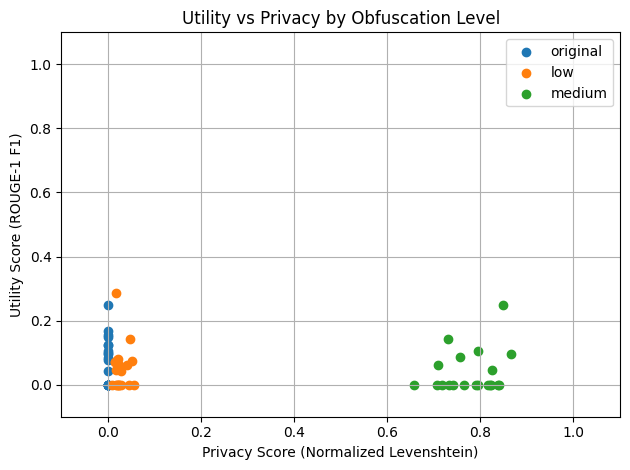

In [48]:
import matplotlib.pyplot as plt

plt.figure()

for level in scores_df["Obfuscation level"].unique():
    subset = scores_df[scores_df["Obfuscation level"] == level]
    plt.scatter(
        subset["Privacy Score"],
        subset["Utility Score"],
        label=level
    )

plt.ylabel("Utility Score (ROUGE-1 F1)")
plt.xlabel("Privacy Score (Normalized Levenshtein)")
plt.title("Utility vs Privacy by Obfuscation Level")

plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()